# Regression Examples using Kaggle House Prices Competition

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sbavery/ml-examples/blob/main/nbs/01_regression.ipynb)

Includes some starting code from [Ayman M.'s notebook on Kaggle](https://www.kaggle.com/code/csmohamedayman/house-prices-advanced-regression-technique/notebook?scriptVersionId=105889177)

In [ ]:
#| hide
"""
!pip install seaborn
!pip install statsmodels
!pip install graphviz
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install mlxtend
!pip install kaggle
"""
print("")

In [ ]:
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import os
from fastai.imports import *
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from numpy import random
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz

from xgboost                 import XGBRegressor
from catboost                import Pool
from catboost                import CatBoostRegressor
from lightgbm                import LGBMRegressor
from sklearn.svm             import SVR
from sklearn.naive_bayes     import GaussianNB
from sklearn.tree            import DecisionTreeRegressor
from mlxtend.regressor       import StackingRegressor
from sklearn.linear_model    import LinearRegression, BayesianRidge, ElasticNet, Lasso, \
                                    LassoLarsIC, Ridge, RidgeCV, LassoCV, LassoLarsCV, SGDRegressor
from sklearn.model_selection import RepeatedKFold, KFold, cross_val_score, train_test_split, \
                                    GridSearchCV, RandomizedSearchCV
from sklearn.ensemble        import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics         import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.kernel_ridge    import KernelRidge
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import RobustScaler, PolynomialFeatures
from sklearn.base            import BaseEstimator, TransformerMixin, RegressorMixin, clone
#from dtreeviz.trees import *
#from IPython.display import Image, display_svg, SVG
np.set_printoptions(linewidth=130)

In [ ]:
if (os.path.exists('data'),os.getcwd().__contains__('data')) == False: os.mkdir('data')
if os.getcwd().__contains__('data') == False: os.chdir('data')
os.getcwd()

'/home/ses/workspace/ml-examples/nbs/data'

If you haven't already set up to use Kaggle, see: https://adityashrm21.github.io/Setting-Up-Kaggle/

In [ ]:
dataset_name='house-prices-advanced-regression-techniques'
display=True
ensemble=3   # Ensemble using the best n models
%matplotlib inline

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path(dataset_name)
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

if iskaggle: path = Path('../input/'+dataset_name)
if display: path.ls()

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Read Training and Test Data
df_orig = pd.read_csv(path/'train.csv')
df = df_orig.copy()
tst_df_orig = pd.read_csv(path/'test.csv')
tst_df = tst_df_orig.copy()
modes = df.mode().iloc[0]

In [ ]:
def compare_columns(df1, df2, display=False):
    df1_columns_set = set(df1.columns)
    df2_columns_set = set(df2.columns)
    if display: print('df1_columns_set - df2_columns_set :', df1_columns_set - df2_columns_set)
    if display: print('df2_columns_set - df1_columns_set :', df2_columns_set - df1_columns_set)
    
compare_columns(df, tst_df, display)

df1_columns_set - df2_columns_set : {'SalePrice'}
df2_columns_set - df1_columns_set : set()


In [ ]:
dep = 'SalePrice'
ind = 'Id'

In [ ]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [ ]:
# Replace all NAs
if display: print(df.isna().sum())
if display: print("\n\n#### Replace all NAs ####\n")
df.fillna(modes, inplace=True)
tst_df.fillna(modes, inplace=True)
if display: print(df.isna().sum())

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64


#### Replace all NAs ####

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64


In [ ]:
cat_table = df.describe(include=[object])
cats = [cat for cat in cat_table if cat not in [dep,ind]]
num_table = df.describe(include=(np.number))
nums = [num for num in num_table if num not in [dep,ind]]

In [ ]:
def proc_data(df, dep, ind, display=False):  
    df2 = df.copy()
    
    cat_table = df2.describe(include=[object])
    cats = [cat for cat in cat_table if cat not in [dep,ind]]
    num_table = df2.describe(include=(np.number))
    nums = [num for num in num_table if num not in [dep,ind]]
    
    if display == True: 
        print("Categorical Variables:\n"); print(cats)
        print("\nNumerical Variables:\n"); print(nums)
        
    for cat in cats:
        df2[cat] = pd.Categorical(df2[cat])
        
    for num in nums:
        df2[num] = np.log1p(df2[num])
    
    return df2

if display: print("Training Dataframe\n")
df_proc = proc_data(df, dep, ind, display)
if display: print("\n\nTesting Dataframe\n")
df_tst_proc = proc_data(tst_df, dep, ind, display)

Training Dataframe

Categorical Variables:

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

Numerical Variables:

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt

In [ ]:
#df_proc = pd.get_dummies(df_proc)
if display: print(df_proc)

        Id  MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0        1    4.110874       RL     4.189655  9.042040   Pave  Grvl      Reg   
1        2    3.044522       RL     4.394449  9.169623   Pave  Grvl      Reg   
2        3    4.110874       RL     4.234107  9.328212   Pave  Grvl      IR1   
3        4    4.262680       RL     4.110874  9.164401   Pave  Grvl      IR1   
4        5    4.110874       RL     4.442651  9.565284   Pave  Grvl      IR1   
...    ...         ...      ...          ...       ...    ...   ...      ...   
1455  1456    4.110874       RL     4.143135  8.976894   Pave  Grvl      Reg   
1456  1457    3.044522       RL     4.454347  9.486152   Pave  Grvl      Reg   
1457  1458    4.262680       RL     4.204693  9.109746   Pave  Grvl      Reg   
1458  1459    3.044522       RL     4.234107  9.181735   Pave  Grvl      Reg   
1459  1460    3.044522       RL     4.330733  9.204121   Pave  Grvl      Reg   

     LandContour Utilities  ... PoolAre

In [ ]:
df_proc[cats] = df_proc[cats].apply(lambda x: x.cat.codes)
if display: print(df_proc)
df_tst_proc[cats] = df_tst_proc[cats].apply(lambda x: x.cat.codes)

        Id  MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  \
0        1    4.110874         3     4.189655  9.042040       1      0   
1        2    3.044522         3     4.394449  9.169623       1      0   
2        3    4.110874         3     4.234107  9.328212       1      0   
3        4    4.262680         3     4.110874  9.164401       1      0   
4        5    4.110874         3     4.442651  9.565284       1      0   
...    ...         ...       ...          ...       ...     ...    ...   
1455  1456    4.110874         3     4.143135  8.976894       1      0   
1456  1457    3.044522         3     4.454347  9.486152       1      0   
1457  1458    4.262680         3     4.204693  9.109746       1      0   
1458  1459    3.044522         3     4.234107  9.181735       1      0   
1459  1460    3.044522         3     4.330733  9.204121       1      0   

      LotShape  LandContour  Utilities  ...  PoolArea  PoolQC  Fence  \
0            3            3          0 

In [ ]:
#from sklearn.preprocessing import PowerTransformer
#boxcox = PowerTransformer(method="box-cox", standardize=False)
#boxcox.fit(cat_df)
#train_transformed = boxcox.transform(cat_df)
#test_tranformed = boxcox.transform(tst_df)

In [ ]:
random.seed(42)
trn_df,val_df = train_test_split(df_proc, test_size=0.25)
#trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
#val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

In [ ]:
def xs_y(df, cols, dep):
    xs = df[cols].copy()
    return xs,df[dep] if dep in df else None

xs,y = xs_y(df_proc, cats+nums, dep)
y_l = np.log1p(y)
trn_xs,trn_y = xs_y(trn_df, cats+nums, dep)
val_xs,val_y = xs_y(val_df, cats+nums, dep)
tst_xs,_ = xs_y(df_tst_proc, cats+nums, dep)

In [ ]:
trn_scores, val_scores = [], []
def rmse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return rmse(m.predict(xs), y)
def model_trn_val(m, trn_xs, trn_y, val_xs, val_y):
    m.fit(trn_xs, trn_y)
    trn_scores.append(m_rmse(m, trn_xs, trn_y))
    val_scores.append(m_rmse(m, val_xs, val_y))

In [ ]:
# K Fold Cross validation
kf = KFold(n_splits=5, shuffle=True)
cv_scores, cv_std = [], []

def rmse_kfold(m, xs, y):
    return np.sqrt(-cross_val_score(m, xs, y, scoring="neg_mean_squared_error", cv=kf))
def model_kfold(m, xs, y):
    score = rmse_kfold(m, xs, y)
    cv_scores.append(score.mean())
    cv_std.append(score.std())

In [ ]:
models = {
    'XGBRegressor':XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1),
    'RandomForestRegressor':RandomForestRegressor(n_estimators=1000),               # Random Forest Regressor
    'GradientBoostingRegressor':GradientBoostingRegressor(             # Gradient Boost Regressor
                      n_estimators=3000, 
                      learning_rate=0.05,
                      max_depth=4, 
                      max_features='sqrt',
                      min_samples_leaf=15, 
                      min_samples_split=10, 
                      loss='huber'),
    'CatBoostRegressor':CatBoostRegressor(silent=True),                   # Cat Boost Regressor   
    'DecisionTreeRegressor':DecisionTreeRegressor(max_leaf_nodes=60),
    'Ridge':Ridge(alpha = 10),
    'LassoCV':LassoCV(alphas = [1, 0.1, 0.001, 0.0005]),
    'LinearRegression':LinearRegression(),                               # Linear Regression
    'BayesianRidge':BayesianRidge(compute_score=True),     # Bayesian Ridge Regression
    'SVR':SVR(kernel='rbf', C=1000000, epsilon=0.001),                                 # Support Vector Regression
}
"""'LGBMRegressor':LGBMRegressor(                         # Light Gradient Boost Regressor
                      objective='regression',
                      num_leaves=5,
                      learning_rate=0.05, 
                      n_estimators=720,
                      max_bin = 55, 
                      bagging_fraction = 0.8,
                      bagging_freq = 5, 
                      feature_fraction = 0.2319,
                      feature_fraction_seed=9, 
                      bagging_seed=9,
                      min_data_in_leaf =6, 
                      min_sum_hessian_in_leaf = 11),
    'XGBRegressor2':XGBRegressor(                          # XGB Regressor
                      colsample_bytree=0.4603, 
                      gamma=0.0468, 
                      learning_rate=0.05, 
                      max_depth=3, 
                      min_child_weight=1.7817, 
                      n_estimators=2200,
                      reg_alpha=0.4640, 
                      reg_lambda=0.8571,
                      subsample=0.5213),
    'StackingRegressor':StackingRegressor(                     # Stacked Regressor
                      regressors=(CatBoostRegressor(silent=True),
                                  LinearRegression(),
                                  BayesianRidge(),
                                  GradientBoostingRegressor()),
                                  meta_regressor = CatBoostRegressor(),
                                  use_features_in_secondary = True),
    'Lasso Regression':make_pipeline(                         # Lasso Regression
                      RobustScaler(), 
                      Lasso(alpha =0.0005)),
    'Elastic Net Regression':make_pipeline(                         # Elastic Net Regression
                      RobustScaler(), 
                      ElasticNet(alpha=0.0005, l1_ratio=.9)),
    'Kernel Ridge Regression':KernelRidge(                           # Kernel Ridge Regression
                      alpha=0.6, 
                      kernel='polynomial', 
                      degree=2, 
                      coef0=2.5),
"""
print("")

In [ ]:
if display: print("xs Shape = "+str(xs.shape))
if display: print("y_log Shape = "+str(y_l.shape))

xs Shape = (1460, 79)
y_log Shape = (1460,)


In [ ]:
for model in models:
    if display: print("-------")
    if display: print(model)
    #model_trn_val(models[model], trn_xs, trn_y, val_xs, val_y)
    model_kfold(models[model], xs, y_l)
    if display: print("Score: ",np.round(cv_scores[-1],4))
    if display: print("Stdev: ",np.round(cv_std[-1],4))

-------
XGBRegressor
Score:  0.1257
Stdev:  0.0071
-------
RandomForestRegressor
Score:  0.1413
Stdev:  0.0053
-------
GradientBoostingRegressor
Score:  0.128
Stdev:  0.0215
-------
CatBoostRegressor
Score:  0.1237
Stdev:  0.0128
-------
DecisionTreeRegressor
Score:  0.1963
Stdev:  0.0139
-------
Ridge
Score:  0.1417
Stdev:  0.018
-------
LassoCV
Score:  0.1402
Stdev:  0.013
-------
LinearRegression
Score:  0.1486
Stdev:  0.0247
-------
BayesianRidge
Score:  0.1442
Stdev:  0.0102
-------
SVR
Score:  0.1958
Stdev:  0.0173


In [ ]:
scores = cv_scores
std = cv_std
final_score = pd.DataFrame(list(models.keys()), columns = ['Models'])
final_score['RMSE_mean'] = scores
final_score['RMSE_std'] = std
final_score = final_score.sort_values(by='RMSE_mean').reset_index(drop=True)
if display: print(final_score)

                      Models  RMSE_mean  RMSE_std
0          CatBoostRegressor   0.123683  0.012797
1               XGBRegressor   0.125654  0.007146
2  GradientBoostingRegressor   0.127982  0.021535
3                    LassoCV   0.140234  0.013007
4      RandomForestRegressor   0.141323  0.005340
5                      Ridge   0.141722  0.017958
6              BayesianRidge   0.144173  0.010162
7           LinearRegression   0.148586  0.024670
8                        SVR   0.195830  0.017271
9      DecisionTreeRegressor   0.196279  0.013928


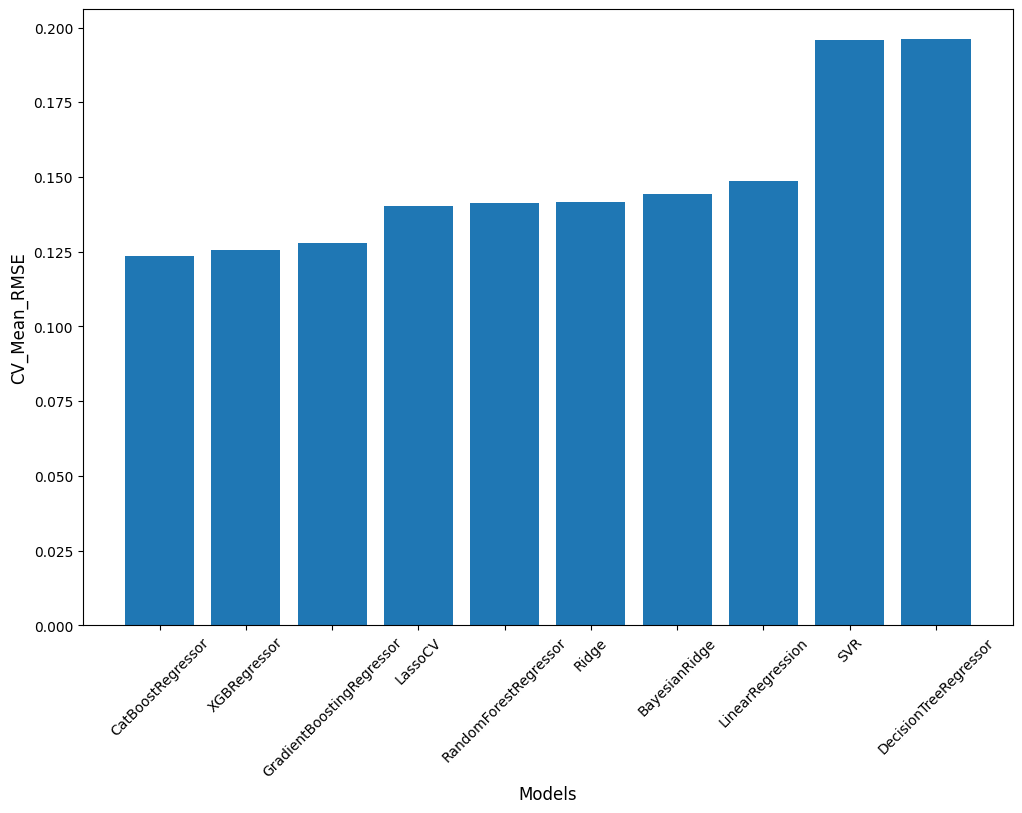

In [ ]:
plt.figure(figsize = (12,8))
plt.bar(final_score['Models'],final_score['RMSE_mean'])
plt.xlabel('Models', fontsize = 12)
plt.ylabel('CV_Mean_RMSE', fontsize = 12)
plt.xticks(rotation=45)
plt.show()

In [ ]:
preds_combined = []
for idx in range(0,ensemble):
    model = final_score['Models'][idx]
    m = models[model].fit(trn_xs, trn_y)
    if display: print(model+" Train RMSE = "+str(m_rmse(m, trn_xs, trn_y)))
    if display: print(model+" Val RMSE = "+str(m_rmse(m, val_xs, val_y)))
    preds_combined.append(m.predict(tst_xs))

preds = np.average(preds_combined, axis=0)
if display: preds

CatBoostRegressor Train RMSE = 5181.261045
CatBoostRegressor Val RMSE = 24961.123287
XGBRegressor Train RMSE = 13309.511261
XGBRegressor Val RMSE = 29105.889011
GradientBoostingRegressor Train RMSE = 13180.691445
GradientBoostingRegressor Val RMSE = 24775.905166


In [ ]:
#def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
#    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
#                      special_characters=True, rotate=False, precision=precision, **kwargs)
#    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

#draw_tree(m, trn_xs, size=10)

In [ ]:
#samp_idx = np.random.permutation(len(trn_y))[:500]
#dtreeviz(m, trn_xs.iloc[samp_idx], trn_y.iloc[samp_idx], trn_xs.columns, dep,
#        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
#        orientation='LR')

In [ ]:
def subm(df, dep, preds):
    df[dep] = preds
    sub_df = df[['Id',dep]]
    sub_df.to_csv(f'submission.csv', index=False)

subm(df_tst_proc, dep, preds)